In [44]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
%autoreload 2

In [70]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import classification_report

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

import pickle

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from imblearn.over_sampling import SMOTE


from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')

from utilities import fit_and_cross_validate_score_model, plot_distribution_pair, fit_and_cross_validate_score_roc_auc, fit_and_cross_validate_score_roc_auc_xgboost

# use grid search cv to select model hyperparameters for each model, then use ROC curve comparison to choose model with highest AUC?

In [51]:
# to open pickled data

with open("MVP_patientlevel_intubation.pkl", 'rb') as picklefile: 
    patients = pickle.load(picklefile)

patients.head()

id  Age  Patient_Gender  Pneumonia  Pregnant  Indigenous  Diabetic  \
0  35483   50               0          1         0           0         0   
1   7062   25               1          0         0           0         0   
2  13779   29               1          0         0           0         0   
3  17334   30               0          0         0           0         0   
4   2789   64               0          0         0           0         1   

   COPD_Lung_Disease  Asthma  Immunosuppressed  Hypertension  Comorbidity  \
0                  0       0                 0             0            0   
1                  0       0                 0             0            0   
2                  0       0                 0             0            0   
3                  0       0                 0             0            0   
4                  0       0                 0             1            0   

   Cardiovascular_Disease  Obese  Chronic_Renal_Insufficiency  Intensive_Care  \
0                       0      0                            0               0   
1                       0      1                            0               0   
2                       0      0                            0               0   
3                       0      0                            0               0   
4                       0      1                            0               0   

   Intubation  
0           0  
1           0  
2           0  
3           0  
4           0

In [52]:
patients.shape

(98820, 17)

In [53]:
patients.Intubation.value_counts()

0    96726
1     2094
Name: Intubation, dtype: int64

Setup models: with oversampling

In [57]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=0)
X = patients.drop(['id', 'Intubation'], axis=1)
y = patients['Intubation']
X_resampled, y_resampled = ros.fit_sample(X, y)

In [58]:
Counter(y_resampled)

Counter({0: 96726, 1: 96726})

In [59]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

<AxesSubplot:>

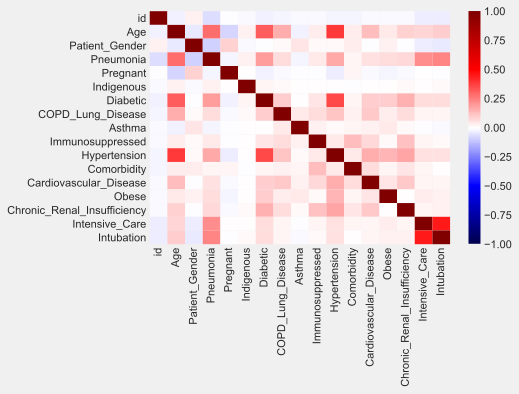

In [84]:
sns.heatmap(patients.corr(), cmap='seismic', vmin=-1, vmax=1)

In [33]:
#df_train = X_train_val.copy()
#df_train['Intubation'] = y_train_val

In [9]:
#X_train_val_baseline = patients.drop(['id'], axis=1)
#y_train_val_baseline = patients['Intubation']
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
baseline_models = [
    ('Dummy', DummyClassifier(strategy="most_frequent")),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=0)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=0)),
]

In [62]:
metrics = []
roc_auc = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_model(estimator, X_train_val, y_train_val))
    roc_auc.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))

pd.DataFrame(metrics)

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Model   ROC AUC  Accuracy  Precision (False)  Recall (False)  \
0                Dummy  0.500000  0.497600           0.398830        0.800000   
1  K-Nearest Neighbors  0.956435  0.910139           0.946808        0.869224   
2        Random Forest  0.975181  0.923831           0.972933        0.871945   
3        Decision Tree  0.972813  0.923004           0.973269        0.869926   
4          Naive Bayes  0.915386  0.804473           0.780515        0.847265   
5  Logistic Regression  0.933228  0.867014           0.952321        0.772757   

   F1 Score (False)  Precision (True)  Recall (True)  F1 Score (True)  
0          0.532292          0.098769       0.200000         0.132235  
1          0.906320          0.879109       0.951074         0.913648  
2          0.919664          0.883972       0.975734         0.927581  
3          0.918688          0.882401       0.976095         0.926878  
4          0.812513          0.832919       0.761689         0.795704  
5          0.853189          0.808758       0.961303         0.878453

In [63]:
pd.DataFrame(roc_auc)

Model  ROC AUC (Train)  ROC AUC (Val)
0                Dummy         0.500000       0.500000
1  K-Nearest Neighbors         0.961257       0.956435
2        Random Forest         0.979163       0.975181
3        Decision Tree         0.979233       0.972675
4          Naive Bayes         0.915515       0.915386
5  Logistic Regression         0.933332       0.933228

Rerun with balanced classes through oversampling

/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/michaeljehl/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_depre

[22:50:25] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


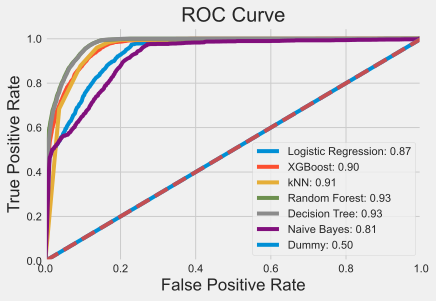

In [69]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(random_state=0),
},
{
    'label': 'XGBoost',
    'model': XGBClassifier(),
},
{
    'label': 'kNN',
    'model': KNeighborsClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(random_state=0),
},
    {
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(),
},
    {
    'label': 'Naive Bayes',
    'model': GaussianNB(),
},
        {
    'label': 'Dummy',
    'model': DummyClassifier(strategy="most_frequent"),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_val, y_train_val) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s: %0.2f' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()   # Display

<ipython-input-119-ca47a4be51ce>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


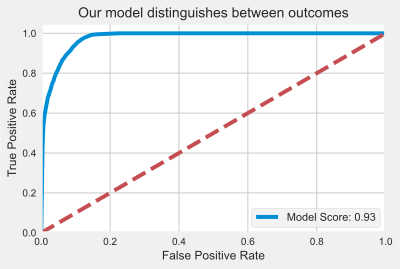

In [119]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Model Score',
    'model': RandomForestClassifier(random_state=0),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_val, y_train_val) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s: %0.2f' % (m['label'], auc))
# Custom settings for the plot 

plt.plot([0, 1], [0, 1],'r--')
ax = plt.axes()
ax.set_facecolor("white")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.tick_params(axis='both', labelsize=10, pad=5)
plt.title('Our model distinguishes between outcomes', fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
plt.legend(loc="lower right")
plt.savefig('rocfinal.png')
plt.show()   # Display

In [79]:
def make_confusion_matrix(model, threshold=0.3):
    # Predict Intubated if probability of being Intubated is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    patients_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(patients_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Intubated', 'Intubated'],
           yticklabels=['Not Intubated', 'Intubated']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
    # print classification report 
    target_names = ['Not Intubated', 'Intubated']
    print(classification_report(y_test, y_predict, target_names=target_names))

In [80]:
clf = RandomForestClassifier(random_state=0).fit(X_train_val, y_train_val)

In [82]:
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(clf, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

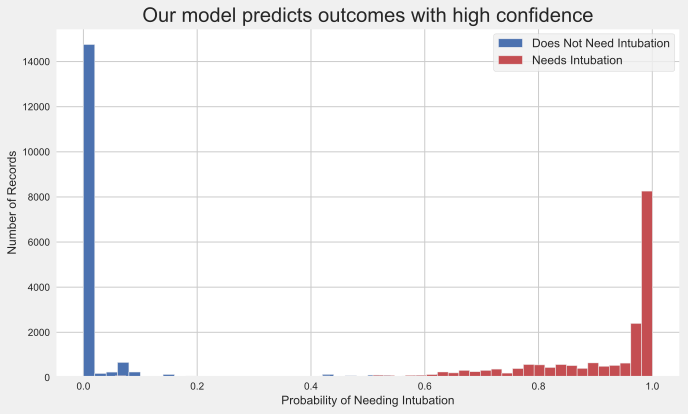

In [105]:

#X, y = make_classification(n_samples=1000, n_features=4,
                          # n_informative=2, n_redundant=0,
                          # random_state=1, shuffle=False)


#lr=LogisticRegression(random_state=0, solver='lbfgs', max_iter=10)
#lr.fit(X, y)

prediction=clf.predict_proba(X_test)[:,1]

plt.figure(figsize=(10,6))
ax = plt.axes()
ax.set_facecolor("white")
plt.hist(prediction[y_test==0], bins=50, label='Does Not Need Intubation', color='b')
plt.hist(prediction[y_test==1], bins=50, label='Needs Intubation', color='r')
plt.xlabel('Probability of Needing Intubation', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.legend(fontsize=12)
plt.tick_params(axis='both', labelsize=10, pad=5)
plt.title('Our model predicts outcomes with high confidence')
plt.savefig('conf.png')
plt.show()
